In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

## Color Palette

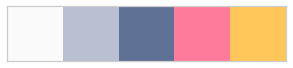

In [2]:
COLOR_BACKGROUND = '#fafafa'
ACCENT_COLORS = ['#FF7B9C', '#FFC759']
MUTED_COLORS = ['#BABFD1', '#607196']
COLORS = [*MUTED_COLORS, *ACCENT_COLORS]
COLOR_PALETTE = sns.color_palette(COLORS, as_cmap=True)
sns.palplot([COLOR_BACKGROUND] + COLORS)

In [3]:
# set background color
plt.rcParams['axes.facecolor']= COLOR_BACKGROUND
plt.rcParams['savefig.facecolor']= COLOR_BACKGROUND

In [4]:
def random_color(accent=False):
    c = ACCENT_COLORS if accent else MUTED_COLORS
    return np.random.choice(c)

random_color()

'#607196'

## Load data

In [5]:
URL_MOVIE_DESCRIPTION = 'https://datasets.imdbws.com/title.basics.tsv.gz'
URL_MOVIE_RATINGS = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

In [6]:
df_movies = pd.read_csv(URL_MOVIE_DESCRIPTION, sep='\t')
df_ratings = pd.read_csv(URL_MOVIE_RATINGS, sep='\t')

df = df_movies.merge(df_ratings, on='tconst', how='left')
del df_movies, df_ratings

df.head()

/home/jumbo/.cache/pypoetry/virtualenvs/mars-venus-dxxCsHEx-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1846.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,239.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1615.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.0,155.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2437.0


In [7]:
df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating',
       'numVotes'],
      dtype='object')

In [8]:
# use np.nan instead of string fill value
df = df.replace('\\N',np.NaN)

# Filter out non-movies and porn movies
df = df.query('(titleType == "movie") and (isAdult ==0)')

# preprocess columns
df = df.drop(['titleType', 'isAdult', 'endYear'], axis=1)
df.columns = ['movie_id', 'primary_title', 'original_title', 'release_year', 'duration', 'genres',
             'rating', 'num_votes']

df.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,rating,num_votes
498,tt0000502,Bohemios,Bohemios,1905,100,NaN,4.5,14.0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.1,744.0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.2,16.0


In [9]:
# preprocess year
df = df[df.release_year.notnull()]
df.release_year = df.release_year.astype(int)
df = df.query('release_year >= 1960')
print(f'Dataset contains {df.shape[0]:,} movies released since 1960')

# remove movies that were not released yet
df = df[df.release_year < 2022]

Dataset contains 418,847 movies released since 1960


In [10]:
# extract romance genre
print(f'{round(df.genres.isnull().sum() / df.shape[0] * 100,2)}% have no genre information.')
df = df[df.genres.notnull()]
df['is_romance'] = df.genres.str.lower().str.contains('romance')

pct_romance = df.is_romance.sum() / df.shape[0] * 100
print(f'{round(pct_romance,2)}% of movies have romantic plot.')

10.34% have no genre information.
8.47% of movies have romantic plot.


Text(0.5, 1.0, 'How Many Movies Were Released This Year?')

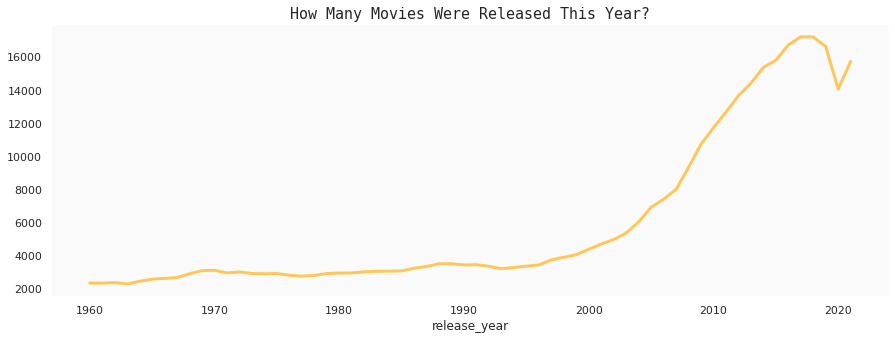

In [11]:
plt.figure(figsize=(15,5))
df.groupby('release_year').count().primary_title.plot(color=random_color(True), lw=3)
sns.despine(bottom = True, left = True)
plt.title('How Many Movies Were Released This Year?', fontsize=15, fontfamily='monospace')

Text(0.5, 1.0, 'Proportion of Romantic Movies By Year')

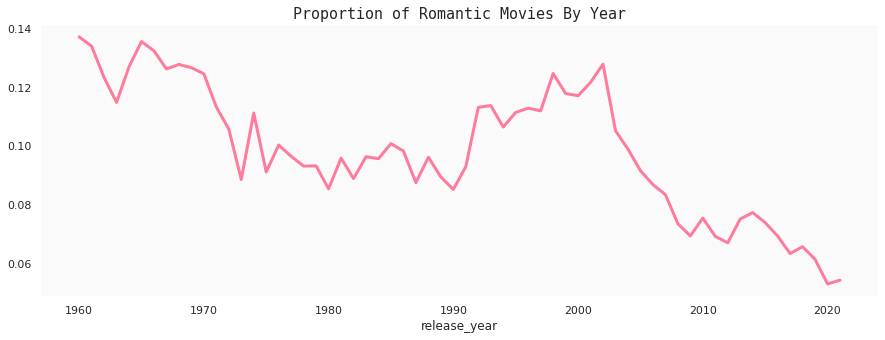

In [12]:
plt.figure(figsize=(15,5))
df.groupby('release_year').apply(lambda year: year.is_romance.sum() / year.shape[0])\
        .plot(color=random_color(True), lw=3)
sns.despine(bottom = True, left = True)
plt.title('Proportion of Romantic Movies By Year', fontsize=15, fontfamily='monospace')

## Add Ratings

In [13]:
df_romances = df.query('is_romance')
df_romances.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
15487,tt0015724,Dama de noche,Dama de noche,1993,102,"Drama,Mystery,Romance",6.2,25.0,True
34805,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,82503.0,True
46189,tt0047027,La gitana y el charro,La gitana y el charro,1964,87,"Comedy,Musical,Romance",4.8,15.0,True


In [14]:
# remove when duration over 3 hours 
# preprocess duration
df_romances = df_romances[df_romances.duration.notnull()]
df_romances.duration = df_romances.duration.astype(int)
df_romances = df_romances[df_romances.duration <= 180]

Text(0.5, 1.0, 'How Long are the Romantic Movies?')

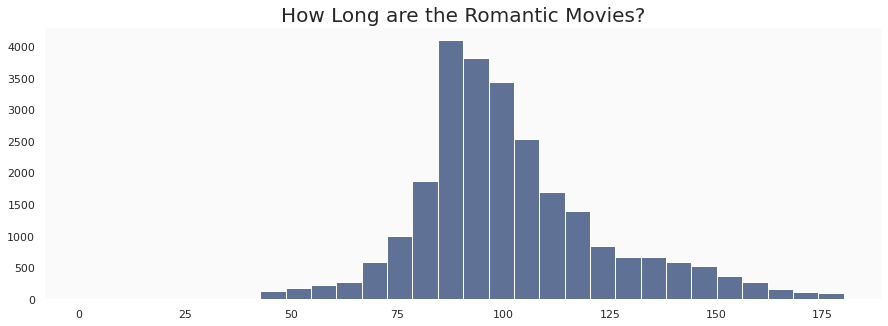

In [15]:
plt.figure(figsize=(15,5))
df_romances.duration.hist(bins=30, color=random_color())
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.title('How Long are the Romantic Movies?', fontsize=20)

Text(0.5, 1.0, 'How Romantic Movies Are Rated?')

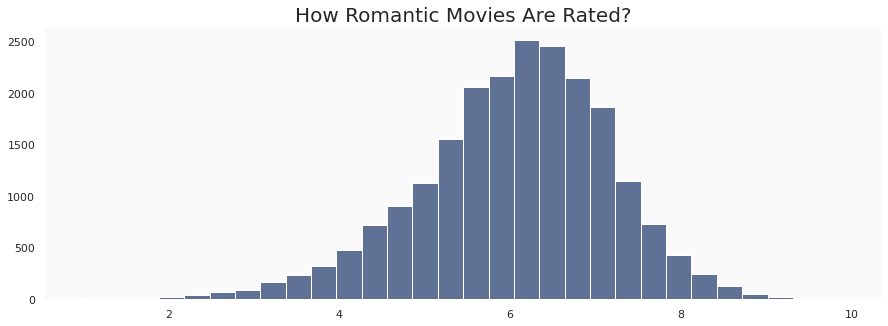

In [16]:
plt.figure(figsize=(15,5))
df_romances.rating.hist(bins=30, color=random_color())
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.title('How Romantic Movies Are Rated?', fontsize=20)

In [17]:
num_no_votes = df_romances[df_romances.num_votes.isnull()].shape[0] / df.shape[0] * 100
print(f'{round(num_no_votes,2)}% of movies have no votes on IMDB.')

df_romances = df_romances[df.num_votes.notnull()]
df_romances.shape[0]

1.05% of movies have no votes on IMDB.


/tmp/ipykernel_228/838461458.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_romances = df_romances[df.num_votes.notnull()]


21736

<AxesSubplot:xlabel='num_votes', ylabel='rating'>

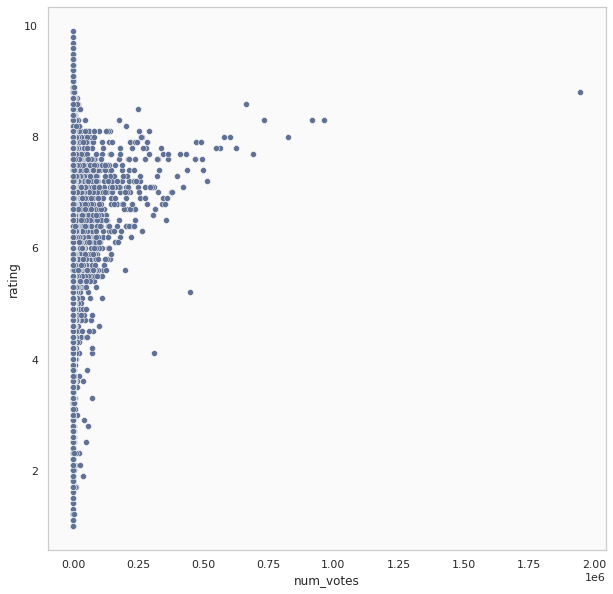

In [18]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_romances, x='num_votes', y='rating', color=random_color())

In [19]:
pct_foreign = df_romances[df_romances.primary_title != df_romances.original_title].shape[0] / df_romances.shape[0]
df_romances = df_romances.query('primary_title == original_title')

In [20]:
TOP_YEAR = 10
data = df_romances.groupby('release_year')\
    .apply(lambda y: y.sort_values(by='num_votes', ascending=False).iloc[:TOP_YEAR])\
    .set_index('movie_id').sort_values(by='release_year', ascending=False)
data.head()

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
movie_id,,,,,,,,
tt9766332,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",6.7,18270.0,True
tt11080108,The Map of Tiny Perfect Things,The Map of Tiny Perfect Things,2021,98,"Comedy,Fantasy,Romance",6.8,18978.0,True
tt4590256,He's All That,He's All That,2021,88,"Comedy,Romance",4.3,21651.0,True
tt10676012,To All the Boys: Always and Forever,To All the Boys: Always and Forever,2021,109,"Comedy,Drama,Romance",6.3,22693.0,True
tt12676326,Malcolm & Marie,Malcolm & Marie,2021,106,"Drama,Romance",6.7,33882.0,True


In [21]:
data

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
movie_id,,,,,,,,
tt9766332,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",6.7,18270.0,True
tt11080108,The Map of Tiny Perfect Things,The Map of Tiny Perfect Things,2021,98,"Comedy,Fantasy,Romance",6.8,18978.0,True
tt4590256,He's All That,He's All That,2021,88,"Comedy,Romance",4.3,21651.0,True
tt10676012,To All the Boys: Always and Forever,To All the Boys: Always and Forever,2021,109,"Comedy,Drama,Romance",6.3,22693.0,True
tt12676326,Malcolm & Marie,Malcolm & Marie,2021,106,"Drama,Romance",6.7,33882.0,True
...,...,...,...,...,...,...,...,...
tt0053622,BUtterfield 8,BUtterfield 8,1960,109,"Drama,Romance",6.4,6399.0,True
tt0052832,The Fugitive Kind,The Fugitive Kind,1960,119,"Drama,Romance",7.1,6230.0,True
tt0054476,Wild River,Wild River,1960,110,"Drama,History,Romance",7.6,5216.0,True


## Add Actors and Age

In [22]:
data['actress'] = np.nan
data['actress_birth_year'] = np.nan
data['actress_age'] = np.nan

data['actor'] = np.nan
data['actor_birth_year'] = np.nan
data['actor_age'] = np.nan

data['age_gap'] = np.nan

data.head(1)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,actress,actress_birth_year,actress_age,actor,actor_birth_year,actor_age,age_gap
movie_id,,,,,,,,,,,,,,,
tt9766332,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",6.7,18270.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data[data.genres.str.contains('Comedy')].shape[0] / data.shape[0]

0.55

In [24]:
# get names of actors playing romantic couple
# get actors' birth year

In [25]:
def calculate_actress_age(row):
    return row.release_year - row.actress_birth_year

def calculate_actor_age(row):
    return row.release_year - row.actor_birth_year

def calculate_age_gap(row):
    return row.actor_birth_year - row.actress_birth_year

In [ ]:
URL_ACTORS = 'https://datasets.imdbws.com/title.principals.tsv.gz'
df_actors = pd.read_csv(URL_ACTORS, sep='\t')
df_actors.head()